In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dill
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
test change

In [3]:
# Load relevant dataframes, perform basic processing on crime_df_agency to group it by county
crime_df_agency = pd.read_pickle('crime_df_agency.pkl')
crime_df = crime_df_agency.groupby(['county_name', 'year'], as_index = False).sum(numeric_only = True)
crime_df = crime_df.rename(columns = {'county_name': 'county'})

USAandCO_df = pd.read_pickle('USAandCO_df.pkl')

econ_df = pd.read_pickle('econ_df.pkl')

In [4]:
main_df = crime_df.merge(econ_df, on = ['county', 'year'], how = 'left')

In [69]:
# Basic feature engineering.  Calculating rates, avg. values, etc.
scaling = 1  # make it easier to change to e.g. 'rate per 1000 people'
main_df['mvt rate'] = (main_df['mvt offense count'] / main_df['population']) * scaling

## Introduction

Over the past decade, Colorado has seen an alarming surge of motor vehicle thefts (MVT), propelling the state to claim the [highest MVT rate](https://www.nicb.org/news/news-releases/nicb-report-finds-vehicle-thefts-continue-skyrocket-many-areas-us) in the entire United States. Colorado MVT rates are now significantly greater than twice the national average, and the problem appears to be worsening. Though the FBI has not released state and national estimates since 2020, information from [local sources](https://kdvr.com/news/data/colorado-sees-record-number-of-auto-thefts-in-2022/) paints a dire portrait of the [situation](http://www.rmiia.org/auto/auto_theft/colorado_auto_theft_statistics.asp). Just in 2021, the total value of vehicles stolen within Colorado was estimated to be almost \$400 million. The value of vehicles stolen in 2022 [possibly approaches $850 million](https://commonsenseinstituteco.org/on-the-road-to-1-billion-in-vehicles-stolen-the-data-trends-behind-colorados-motor-vehicle-theft-crisis/).

Along with quantifiable economic impact, with [1 in 54 Colorado households falling victim to MVT in 2022](https://csp.colorado.gov/press-release/auto-theft-is-up-and-its-time-to-protect-yourself), it should be noted that vehicle theft is extremely distruptive to the life of the victims.  I know this first hand, as my car was stolen in late February, 2023. Though the vehicle was recovered a few days later, the interior was trashed and tested positive for methamphetamine, with the decontamination and repair costs leaving the vehicle totaled. In the few days they were in possession of my vehicle, the thief also managed to collect four red light / parking tickets, consistent with claims that increased MVT rates have contributed to making Colorado roads less safe due to a ["drive it like you stole it" mentality](https://www.police1.com/traffic-patrol/articles/colorado-sees-all-time-high-for-auto-theft-up-82-since-2019-h3DdA3uAPmJnbs1Y/).

After my car was stolen and I began researching the issue, I found it interesting that this spike appears to be relatively decoupled from other types of crime, or at very least, violent crime. As can be seen in the two plots below, the spike in Colorado MVT since 2014 is a significant divergence from the national average and predates the COVID-19 pandemic. While violent crime rates are also rising, it is proportionally much smaller, and puts CO at barely above the baseline rate. It is also worth noting that local data show that CO MVT rate went up an additional 37\% in 2021.

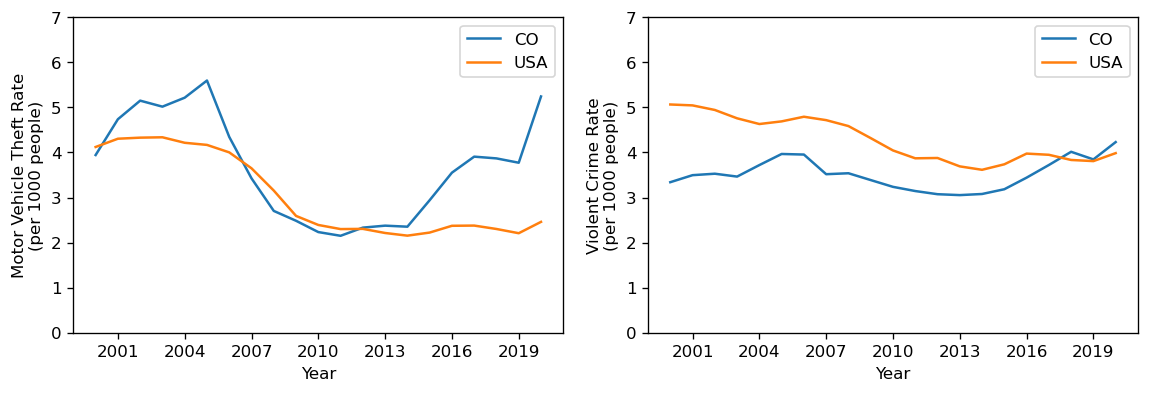

In [73]:
plt.figure(fig1)
plt.show()

Popular explanations for this spike include:
* Legislation in 2014 that [changed the way MVT offenses were prosecuted](https://commonsenseinstituteco.org/on-the-road-to-1-billion-in-vehicles-stolen-the-data-trends-behind-colorados-motor-vehicle-theft-crisis/), with additional changes made during the pandemic
* The rise of [organized car theft](https://www.dea.gov/press-releases/2018/12/12/denver-dea-and-auto-theft-task-force-take-down-black-market-marijuana) rings [operating in CO](https://www.hg.org/legal-articles/the-rise-of-auto-theft-in-denver-26034)
* The legalization and growth of the recreational marijuana industry in 2014 (this one is more popular with fellow CO residents I've talked to)

The precise causes are no doubt complex, and these explanations are not mutually exclusive. However, Colorado has undergone a lot of change during the past decade. What other factors should be considered? [Related to broader socioeconomic explanations](https://lifeoncaphill.com/stories/housing-drug-addiction-prove-to-be-roots-of-motor-vehicle-thefts,403112), I will add: 
* The police officer who recovered my vehicle mentioned many of the car thieves are homeless, and are often living in the vehicles they steal. Could homelessness and poverty predict MVT rates?
* Many stolen vehicles, including mine, test positive for illegal drugs, [especially methamphetamine](https://www.koat.com/article/almost-90-of-stolen-cars-test-positive-for-methamphetamine/19080589). Is MVT associated with changing drug use habits?
* Though violent crime doesn't appear to be correlated, are any other crimes correlated with MVT?

This project seeks to examine these hypotheses and answer these questions using data from the FBI, the US Census Bureau, and other sources.

## Comparing Colorado to national trends

In [8]:
# Calculate rate for different crimes. Column labeled with original title + ' rate'
cols_to_convert = ['violent_crime', 'homicide', 'robbery', 'aggravated_assault', 
                'property_crime', 'burglary', 'larceny', 'motor_vehicle_theft', 'arson']

for column in cols_to_convert:
    new_name = column + ' rate'
    USAandCO_df.loc[:, new_name] = USAandCO_df[column].div(USAandCO_df['population'])

In [68]:
USAandCO_df[USAandCO_df['year']>2018]

,state_abbr,year,population,violent_crime,homicide,robbery,aggravated_assault,property_crime,burglary,larceny,...,arson,violent_crime rate,homicide rate,robbery rate,aggravated_assault rate,property_crime rate,burglary rate,larceny rate,motor_vehicle_theft rate,arson rate
19,USA,2019,328329953,1250393,16669,268483,822017,6995235,1118096,5152267,...,35919,0.003808,0.000051,0.000818,0.002504,0.021306,0.003405,0.015692,0.002208,0.000109
20,USA,2020,329484123,1313105,21570,243600,921505,6452038,1035314,4606324,...,43602,0.003985,0.000065,0.000739,0.002797,0.019582,0.003142,0.013980,0.002460,0.000132
19,CO,2019,5758486,22149,229,3716,14117,150564,20266,108575,...,899,0.003846,0.000040,0.000645,0.002452,0.026146,0.003519,0.018855,0.003772,0.000156
20,CO,2020,5807719,24570,294,3964,16660,164582,23246,110884,...,1330,0.004231,0.000051,0.000683,0.002869,0.028338,0.004003,0.019093,0.005243,0.000229


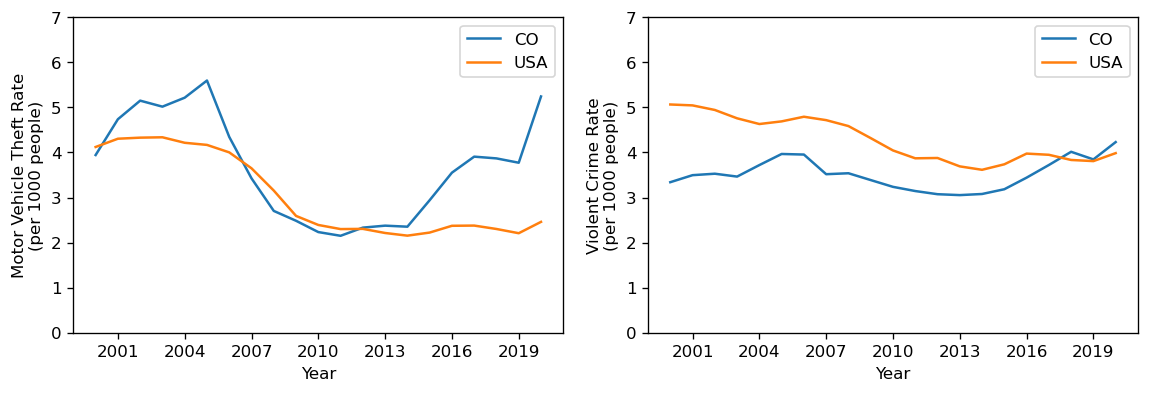

In [64]:
plt.rcParams['figure.dpi'] = 120
scaling = 1000 
figscale = 0.8
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize = (12*figscale,4*figscale))
fig1.tight_layout(w_pad = 2)

#create subplots
for key, grp in USAandCO_df.groupby('state_abbr'):
    grp['motor_vehicle_theft rate'] = grp['motor_vehicle_theft rate']*scaling
    grp['violent_crime rate'] = grp['violent_crime rate']*scaling
    grp.plot(ax = ax1, kind='line', x = 'year', y = 'motor_vehicle_theft rate', label = key)
    grp.plot(ax = ax2, kind='line', x = 'year', y = 'violent_crime rate', label = key)

# Configure subplot 1    
ax1.legend(loc = 'best')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax1.set_xlabel('Year')
ax1.set_ylabel('Motor Vehicle Theft Rate\n(per 1000 people)')
ax1.set_ylim(0, 7)

# Configure subplot 2 
ax2.legend(loc = 'best')
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax2.set_xlabel('Year')
ax2.set_ylabel('Violent Crime Rate\n(per 1000 people)')
ax2.set_ylim(0, 7)

plt.show()

## Analyzing trends in counties

In [36]:
# 10 Counties with highest MVT rate based on totals from years 2000-2021. 
# Rate was just summed-- not meaningful number but sufficient for comparison
highrate10 = main_df.groupby('county').sum().nlargest(10, 'mvt rate')[['mvt rate', 'mvt offense count']]
highrate10

,mvt rate,mvt offense count
county,,
DENVER,0.197920,122601
ADAMS,0.131355,58361
ARAPAHOE,0.105005,60753
PUEBLO,0.097178,15651
JEFFERSON,0.079638,43786
EL PASO,0.073684,46723
MESA,0.045596,6438
BROOMFIELD,0.039947,2377
WELD,0.036764,10010


In [38]:
highcount10 = main_df.groupby('county').sum().nlargest(10, 'mvt offense count')[['mvt offense count', 'mvt rate']]
top10 = list(highcount10.index)
highcount10

,mvt offense count,mvt rate
county,,
DENVER,122601,0.197920
ARAPAHOE,60753,0.105005
ADAMS,58361,0.131355
EL PASO,46723,0.073684
JEFFERSON,43786,0.079638
PUEBLO,15651,0.097178
WELD,10010,0.036764
BOULDER,9739,0.031849
LARIMER,8731,0.028583


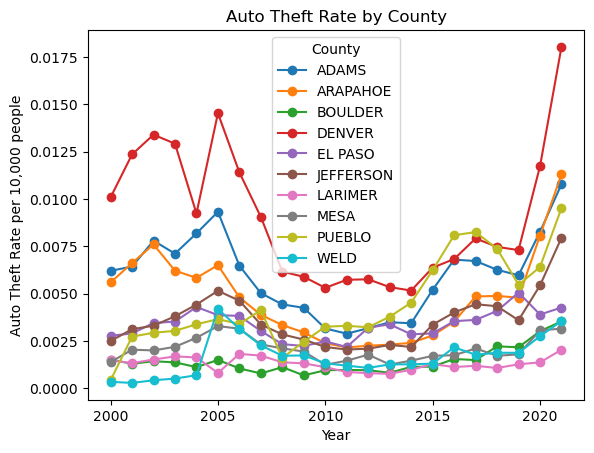

In [41]:
# Probably better solution for multiple plots: 
# https://stackoverflow.com/questions/29233283/plotting-multiple-lines-in-different-colors-with-pandas-dataframe

# Only include counties in top 10 for mvt
plot_df = main_df[main_df['county'].isin(top10)]
plot_df = plot_df.groupby(['county', 'year'], as_index = False).sum()

# Re-arrange data to plot a separate line for each county
plot_df = plot_df.pivot(index='year', columns='county', values='mvt rate')

# Plotting
plot_df.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Auto Theft Rate per 10,000 people')
plt.title('Auto Theft Rate by County')
plt.legend(title='County')

plt.show()

In [17]:
# Population totals seem to be off between 1-30000 per year, probably depending on missing rows in crime_df
# Rates only differ 1-2% from https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/explorer/crime/crime-trend
statesums = main_df.groupby('year').sum()
statesums['mvt state rate'] = (statesums['mvt offense count'] / statesums['population']) * 10000
statesums[['mvt state rate']]

C:\Users\ruggb\AppData\Local\Temp\ipykernel_16392\3232098687.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  statesums = main_df.groupby('year').sum()


,mvt state rate
year,
2000,35.409711
2001,40.936161
2002,45.169635
2003,43.042953
2004,40.817370
2005,51.173517
2006,41.811931
2007,33.150370
2008,25.915541


Text(0.5, 1.0, 'Auto Theft Rate for Colorado')

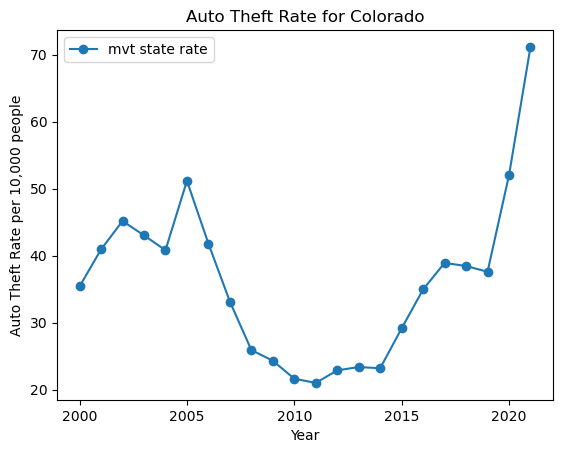

In [18]:
stateplot = statesums[['mvt offense count', 'mvt state rate']]

stateplot.plot(y = 'mvt state rate', kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Auto Theft Rate per 10,000 people')
plt.title('Auto Theft Rate for Colorado')

In [83]:
statesums[['Medical Marijuana Sales', 'Retail Marijuana Sales']]

,Medical Marijuana Sales,Retail Marijuana Sales
year,,
2000,0.0,0.000000e+00
2001,0.0,0.000000e+00
2002,0.0,0.000000e+00
2003,0.0,0.000000e+00
2004,0.0,0.000000e+00
...,...,...
2017,407731909.0,1.035323e+09
2018,323482318.0,1.164430e+09
2019,328797111.0,1.347971e+09


Text(0.5, 1.0, 'Marijuana Sales in Colorado')

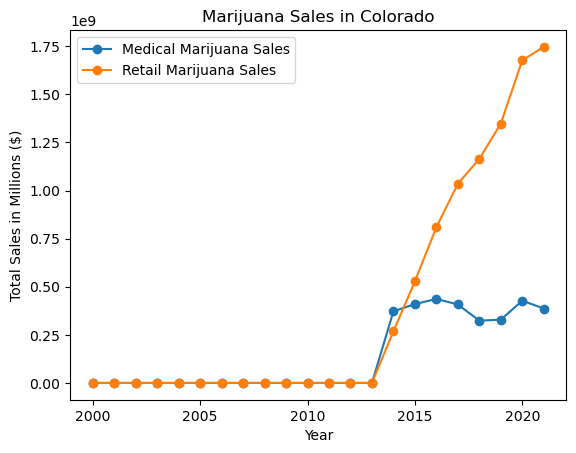

In [87]:
stateweedplot = statesums[['Medical Marijuana Sales', 'Retail Marijuana Sales']]

stateweedplot.plot(kind='line', marker='o')
plt.xlabel('Year')
plt.ylabel('Total Sales in Millions ($)')
plt.title('Marijuana Sales in Colorado')

## Modeling

In [88]:
main_df.columns

Index(['county', 'year', 'mvt stolen value total', 'mvt offense count',
       'mvt cleared', 'burglary value total', 'burglary offense count',
       'robbery value total', 'robbery offense count', 'larceny value total',
       'larceny offense count', 'homicide cleared', 'homicide actual',
       'aggravated-assault cleared', 'aggravated-assault actual',
       'arson cleared', 'arson actual', 'Curfew and Loitering Law Violations',
       'Disorderly Conduct', 'Driving Under the Influence',
       'Drug Abuse Violations - Grand Total', 'Drunkenness', 'Embezzlement',
       'Forgery and Counterfeiting', 'Fraud', 'Gambling - Total',
       'Human Trafficking - Commercial Sex Acts',
       'Human Trafficking - Involuntary Servitude', 'Larceny - Theft',
       'Liquor Laws', 'Manslaughter by Negligence',
       'Offenses Against the Family and Children',
       'Prostitution and Commercialized Vice', 'Rape', 'Simple Assault',
       'Stolen Property: Buying, Receiving, Possessing', 'Susp

In [96]:
analysis_df = main_df[['county', 'year', 'mvt rate', 'population', 
       'median household income', 'all poverty rate', 'age5-17 poverty rate',
       'Medical Marijuana Sales', 'Retail Marijuana Sales']]

In [103]:
cols_to_convert = ['burglary offense count', 'robbery offense count', 'larceny offense count',
       'homicide actual', 'aggravated-assault actual', 'arson actual', 
        'Curfew and Loitering Law Violations', 'Disorderly Conduct', 'Driving Under the Influence',
       'Drug Abuse Violations - Grand Total', 'Drunkenness', 'Embezzlement',
       'Forgery and Counterfeiting', 'Fraud', 'Gambling - Total',
       'Human Trafficking - Commercial Sex Acts',
       'Human Trafficking - Involuntary Servitude',
       'Liquor Laws', 'Manslaughter by Negligence',
       'Offenses Against the Family and Children',
       'Prostitution and Commercialized Vice', 'Rape', 'Simple Assault',
       'Stolen Property: Buying, Receiving, Possessing', 'Suspicion',
       'Vagrancy', 'Vandalism', 'Weapons: Carrying, Possessing, Etc.',
       'Opium or Cocaine or Their Derivatives',
       'Other - Dangerous Nonnarcotic Drugs', 'Synthetic Narcotics']

for column in cols_to_convert:
    new_name = column + ' rate'
    analysis_df.loc[:, new_name] = main_df[column].div(analysis_df['population'])

C:\Users\ruggb\AppData\Local\Temp\ipykernel_17676\2593560705.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.loc[:, new_name] = main_df[column].div(analysis_df['population'])


In [105]:
analysis_df.columns

Index(['county', 'year', 'mvt rate', 'population', 'median household income',
       'all poverty rate', 'age5-17 poverty rate', 'Medical Marijuana Sales',
       'Retail Marijuana Sales', 'burglary offense count rate',
       'robbery offense count rate', 'larceny offense count rate',
       'homicide actual rate', 'aggravated-assault actual rate',
       'arson actual rate', 'Curfew and Loitering Law Violations rate',
       'Disorderly Conduct rate', 'Driving Under the Influence rate',
       'Drug Abuse Violations - Grand Total rate', 'Drunkenness rate',
       'Embezzlement rate', 'Forgery and Counterfeiting rate', 'Fraud rate',
       'Gambling - Total rate', 'Human Trafficking - Commercial Sex Acts rate',
       'Human Trafficking - Involuntary Servitude rate', 'Liquor Laws rate',
       'Manslaughter by Negligence rate',
       'Offenses Against the Family and Children rate',
       'Prostitution and Commercialized Vice rate', 'Rape rate',
       'Simple Assault rate',
       '

In [128]:
X = analysis_df.drop(['mvt rate', 'county', 'year'], axis = 1)
y = analysis_df['mvt rate']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

regressor = LinearRegression()

regressor.fit(X_train, y_train)

LinearRegression()

In [129]:
r2 = regressor.score(X_train, y_train)

print("R-squared on training data:", r2)

R-squared on training data: 0.7475811902374053


In [130]:
r2 = regressor.score(X_test, y_test)

print("R-squared on test data:", r2)

R-squared on test data: 0.7819404484741129


In [124]:
feature_names = X.columns.tolist()

coefficients = regressor.coef_ * 1000

# Create a dictionary mapping feature names to their importance
feature_importance = dict(zip(feature_names, coefficients))

# Sort the feature importance dictionary by values in descending order
sorted_feature_importance = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))

# Print the feature importance
for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance}")

robbery offense count rate: 0.6383631021101165
larceny offense count rate: 0.3707811644803202
Retail Marijuana Sales: 0.32007943104462677
Prostitution and Commercialized Vice rate: 0.2998995836443998
Stolen Property: Buying, Receiving, Possessing rate: 0.1699422981546083
population: 0.1601923322240861
burglary offense count rate: 0.11345996964719408
aggravated-assault actual rate: 0.11143350956403555
Human Trafficking - Commercial Sex Acts rate: 0.09195583288567563
Rape rate: 0.0872650857880359
Weapons: Carrying, Possessing, Etc. rate: 0.07685783332642362
Human Trafficking - Involuntary Servitude rate: 0.07195336345219226
Manslaughter by Negligence rate: 0.05468734790118352
arson actual rate: 0.041022044128909675
age5-17 poverty rate: 0.03201980960516025
Embezzlement rate: 0.021277195296145582
Other - Dangerous Nonnarcotic Drugs rate: 0.02101671563625623
Curfew and Loitering Law Violations rate: 0.015928283863369096
Simple Assault rate: 0.00955668911284532
Suspicion rate: 0.00345797856